In [1]:
# -*- coding: utf-8 -*-
import keras as keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout ,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement=True)

#最多占gpu资源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

#开始不会给tensorflow全部gpu资源 而是按需增加
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# 資料路徑
DATASET_PATH  = 'E:/git/3rd-ML100Days/D101-103/test'

# 影像大小
IMAGE_SIZE = (299, 299)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-InceptionV3-12-24-3.h5'



Using TensorFlow backend.


In [2]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 2323 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [3]:
# 以訓練好的 NASNetLarge  為基礎來建立模型，
base_model = InceptionV3 (include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
x = Dense(1024, activation='relu')(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 构建我们需要训练的完整模型
net_final = Model(inputs=base_model.input, outputs=output_layer)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型（一定要在锁层以后操作）
net_final.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 在新的数据集上训练几代
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 现在顶层应该训练好了，让我们开始微调 Inception V3 的卷积层。
# 我们会锁住底下的几层，然后训练其余的顶层。














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
145/145 [==============================] - 86s 593ms/step - loss: 11.9773 - acc: 0.2504 - val_loss: 12.8685 - val_acc: 0.2016
Epoch 2/20
145/145 [==============================] - 78s 541ms/step - loss: 12.0815 - acc: 0.2504 - val_loss: 12.7879 - val_acc: 0.2066
Epoch 3/20
145/145 [==============================] - 78s 541ms/step - loss: 12.0228 - acc: 0.2523 - val_loss: 12.7879 - val_acc: 0.2066
Epoch 4/20
145/145 [==============================] - 78s 541ms/step - loss: 12.5675 - acc: 0.2168 - val_loss: 12.7879 - val_acc: 0.2066
Epoch 5/20
145/145 [==============================] - 80s 552ms/step - loss: 13.3230 - acc: 0.1734 - val_loss: 12.7879 - val_acc: 0.2066
Epoch 6/20
145/145 [==============================] - 79s 545ms/step - loss: 7.2549 - acc: 0.3293 - val_loss: 12.7283 - val_acc: 0.2066
Epoch 7/20
145/145 [==============================] - 80s 553ms/step - loss:

NameError: name 'net' is not defined

In [4]:
# 让我们看看每一层的名字和层号，看看我们应该锁多少层呢：
for i, layer in enumerate(net_final.layers):
   print(i, layer.name)


0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

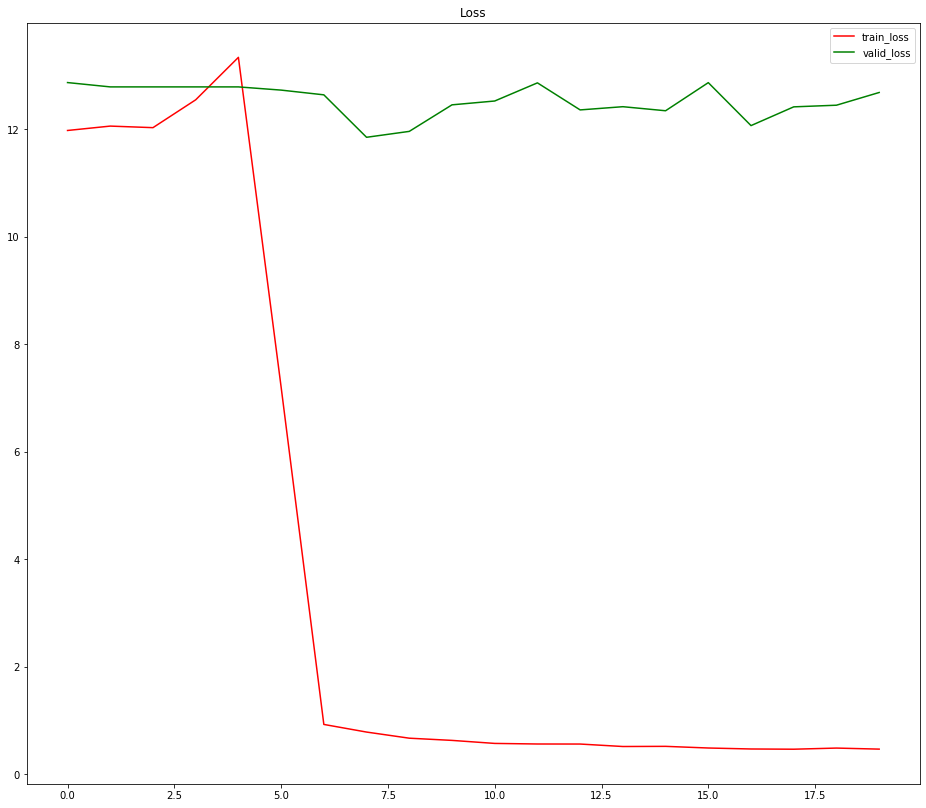

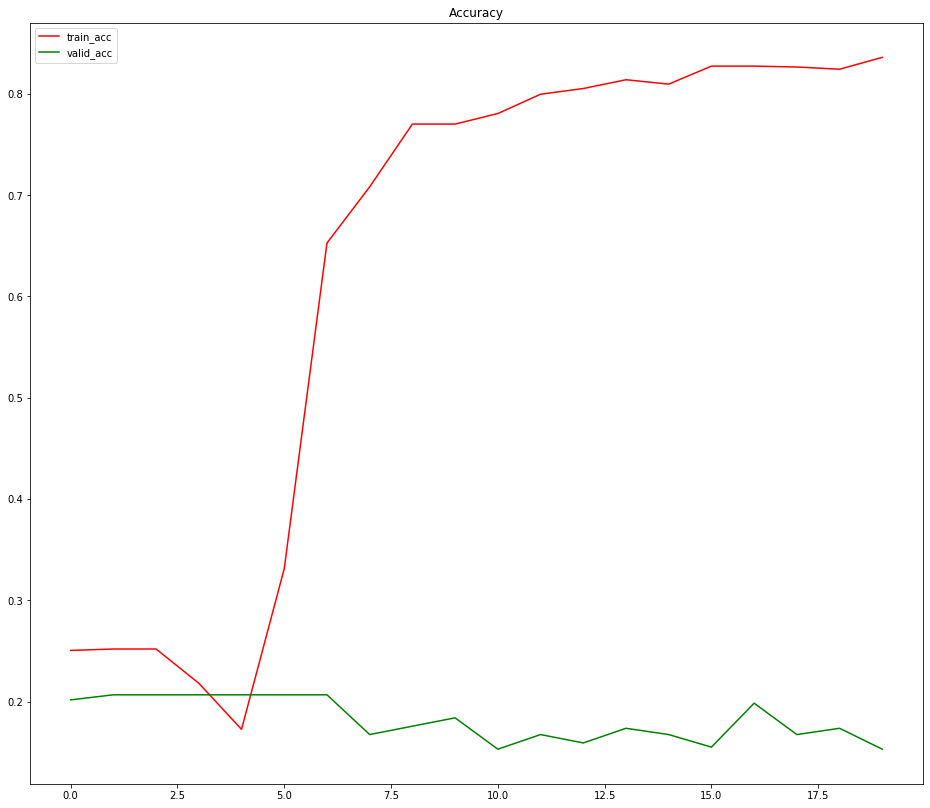

In [5]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()

In [6]:
# 模型輸出儲存的檔案
WEIGHTS_FINAL_BASE = 'model-base-InceptionV3-12-24-3.h5'
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL_BASE)

In [7]:
# 設定凍結與要進行訓練的網路層
#net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [8]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
from keras.optimizers import SGD
net_final.compile(optimizer=SGD(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/20
145/145 [==============================] - 94s 649ms/step - loss: 0.3271 - acc: 0.8822 - val_loss: 0.4182 - val_acc: 0.8657
Epoch 2/20
145/145 [==============================] - 83s 573ms/step - loss: 0.3683 - acc: 0.8614 - val_loss: 0.4221 - val_acc: 0.8678
Epoch 3/20
145/145 [==============================] - 86s 591ms/step - loss: 0.3471 - acc: 0.8707 - val_loss: 0.3973 - val_acc: 0.8719
Epoch 4/20
145/145 [==============================] - 87s 602ms/step - loss: 0.3575 - acc: 0.8659 - val_loss: 0.4159 - val_acc: 0.8719
Epoch 5/20
145/145 [==============================] - 87s 601ms/step - loss: 0.3564 - acc: 0.8684 - val_loss: 0.4137 - val_acc: 0.8678
Epoch 6/20
145/145 [==============================] - 87s 599ms/step - loss: 0.3384 - acc: 0.8726 - val_loss: 0.4111 - val_acc: 0.8698
Epoch 7/20
145/145 [==============================] - 87s 598ms/step - loss: 0.3429 - acc: 0.8809 - val_loss: 0.3861 - val_acc: 0.8802
Epoch 8/20
145/145 [==============================] - 8

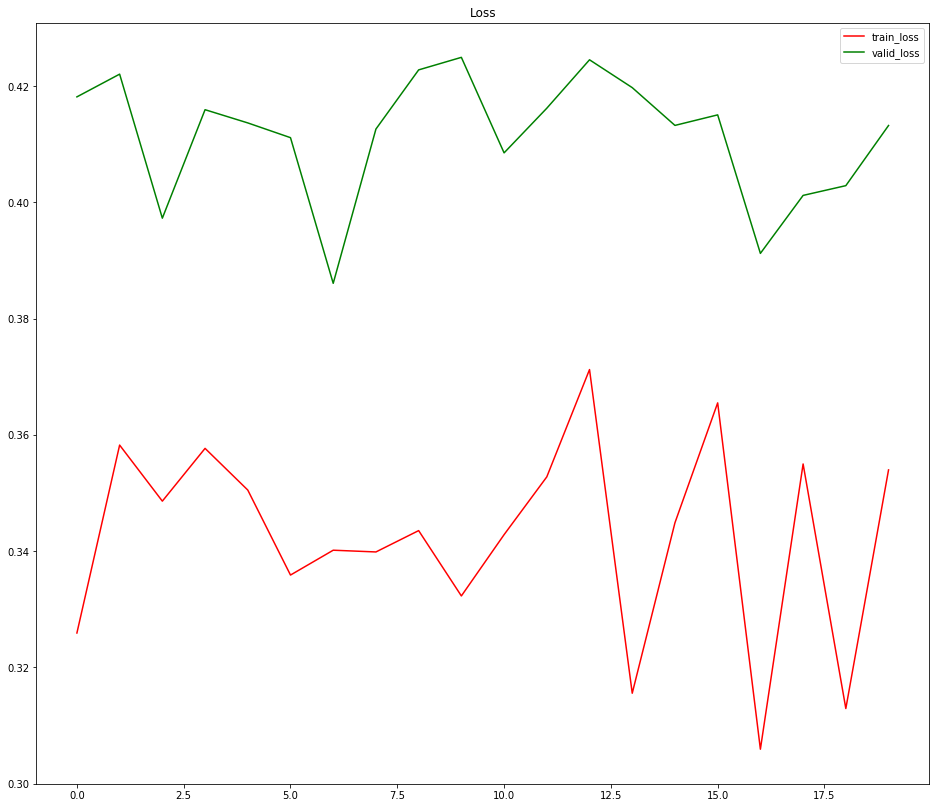

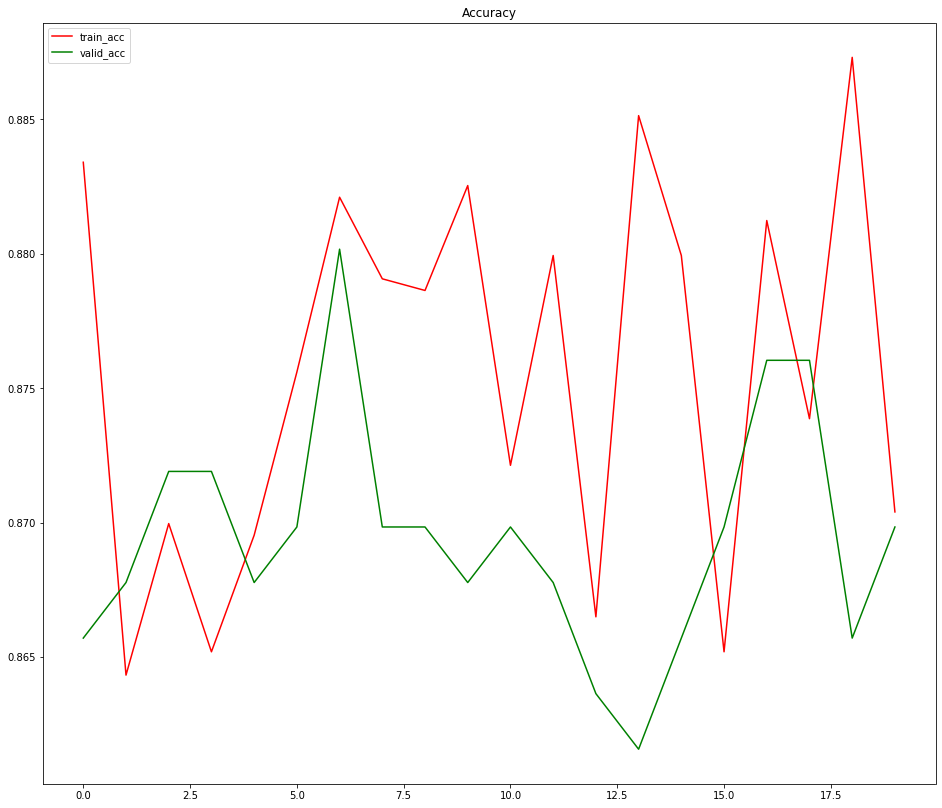

In [9]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()